# This notebook is used to finetune the flan-t5-large model for our task.

We want the model to return a list of (item, target location) tuples from our queries, eg. input="Move the blue ball to the green square" , output=[('blue ball','green square')].

* The dataset is created with relevance to the items used in our specific task in the original github repo.

In [1]:
import torch
import json
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from collections import Counter

## Load tokenizer and model

In [2]:
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(
    model_name
)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

## Load and prepare dataset

In [3]:
# Load the data
data_path = "/content/finetune_dataset.csv"
data = pd.read_csv(data_path)

# Split data into train, validation, and test sets
train_data, eval_data = train_test_split(data, test_size=0.1, random_state=42)

# Reset indices for consistency
train_data.reset_index(drop=True, inplace=True)
eval_data.reset_index(drop=True, inplace=True)

# System text for the llm
SYSTEM_TEXT = "Extract a list of ('item', 'target location') pairs from the following input:"

# Tokenize and preprocess the dataset
def preprocess_dataset(data, tokenizer, max_length=256):
    input_ids, attention_masks, labels = [], [], []

    for _, row in data.iterrows():
        input_text = f"{SYSTEM_TEXT} {row['input']}"
        output_text = row['output']

        # Tokenize input and output
        input_encodings = tokenizer(
            input_text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors="np"
        )
        output_encodings = tokenizer(
            output_text,
            max_length=max_length//2,
            truncation=True,
            padding='max_length',
            return_tensors="np"
        )

        labels_array = output_encodings['input_ids'].squeeze(0)
        labels_array[labels_array == 0] = -100

        input_ids.append(input_encodings['input_ids'].squeeze(0))
        attention_masks.append(input_encodings['attention_mask'].squeeze(0))
        labels.append(output_encodings['input_ids'].squeeze(0))

    return (
        np.array(input_ids),
        np.array(attention_masks),
        np.array(labels)
    )

# Preprocess data
train_input_ids, train_attention_masks, train_labels = preprocess_dataset(train_data, tokenizer)
eval_input_ids, eval_attention_masks, eval_labels = preprocess_dataset(eval_data, tokenizer)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets
train_dataset = CustomDataset(train_input_ids, train_attention_masks, train_labels)
eval_dataset = CustomDataset(eval_input_ids, eval_attention_masks, eval_labels)

## Train model

In [4]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-finetuning",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.05,
    warmup_steps=10,
    logging_steps=30,
    save_steps=50,
    save_total_limit=3,
    predict_with_generate=True,
    eval_strategy="steps",
    report_to=["none"],
)


# Define data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8
)

# Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Train model
print("Starting training...")
train_result = trainer.train()

Starting training...


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
30,1.932600,0.610529
60,0.593000,0.196325
90,0.253400,0.080261
120,0.128000,0.035396
150,0.078400,0.018993
180,0.055400,0.015047
210,0.048100,0.011904
240,0.049800,0.010868
270,0.038400,0.009935


## Plots

In [5]:
def prepare_loss_data(trainer):
    history = trainer.state.log_history

    train_epochs = []
    train_losses = []
    eval_epochs = []
    eval_losses = []

    for entry in history:
        if 'loss' in entry:
            train_epochs.append(entry['step'])
            train_losses.append(entry['loss'])
        elif 'eval_loss' in entry:
            eval_epochs.append(entry['step'])
            eval_losses.append(entry['eval_loss'])

    return train_epochs, train_losses, eval_epochs, eval_losses

# Usage:
train_epochs, train_losses, eval_epochs, eval_losses = prepare_loss_data(trainer)

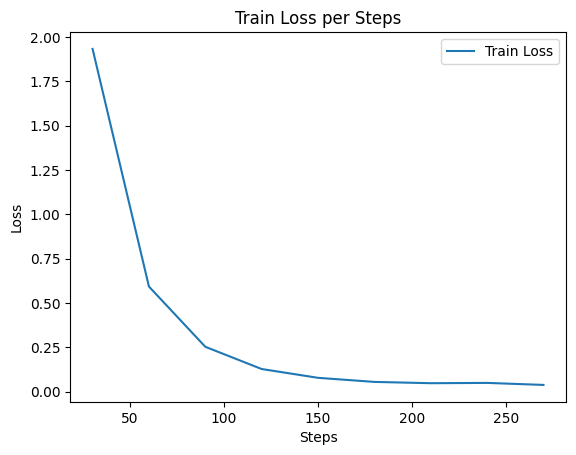

In [6]:
# Training loss

plt.plot(train_epochs, train_losses, label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train Loss per Steps")
plt.legend()
plt.show()

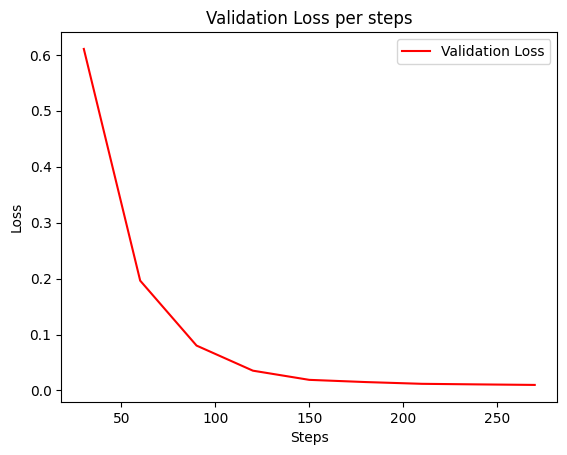

In [7]:
# Validation loss

plt.plot(eval_epochs, eval_losses, label="Validation Loss", color="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss per steps")
plt.legend()
plt.show()

## Save model

In [8]:
# Save the model
trainer.save_model("./flan-t5-finetuned")

# Save the tokenizer
tokenizer.save_pretrained("./flan-t5-finetuned")

print("Model and tokenizer saved to ./flan-t5-finetuned")

Model and tokenizer saved to ./flan-t5-finetuned


In [9]:
import shutil
from google.colab import files

# Define the directory where the model is saved
model_dir = "./flan-t5-finetuned"

# Create a zip file of the model directory
shutil.make_archive(model_dir, 'zip', model_dir)

'/content/flan-t5-finetuned.zip'

## Test the model

In [10]:
import torch
import gc

# Delete the model and variables
del model  # Delete the model if it's loaded
del tokenizer  # Delete the tokenizer if it's loaded
gc.collect()  # Collect garbage to free memory
torch.cuda.empty_cache()  # Clear the PyTorch GPU cache

In [12]:
# Load the fine-tuned model and tokenizer
model_name = "./flan-t5-finetuned"  # Path to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate output for a given input
def generate_output(input_text):
    input_text = f"{SYSTEM_TEXT} {input_text}"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# List of test prompts
test_prompts = [
    "Move the sugar box to the blue bin.",
    "Place the clamp into the yellow can.",
    "Transfer the master can to the red bin.",
    "Put the tuna can in the blue bin.",
    "Bring the sugar to the yellow trash.",
    "Position the large clamp near the red bin.",
    "Take the master chef can to the blue bin.",
    "Shift the tuna can towards the yellow bin.",
    "Set the sugar box by the red bin. after, do  large clamp close to the blue bin."
]

# Generate and print outputs for each test prompt
for prompt in test_prompts:
    output = generate_output(prompt)
    print(f"Input: {prompt}")
    print(f"Output: {output}")
    print("-" * 50)


Input: Move the sugar box to the blue bin.
Output: [('sugar_box', 'blueBin')]
--------------------------------------------------
Input: Place the clamp into the yellow can.
Output: [('large_clamp', 'yellowBin')]
--------------------------------------------------
Input: Transfer the master can to the red bin.
Output: [('master_can', 'redBin')]
--------------------------------------------------
Input: Put the tuna can in the blue bin.
Output: [('tuna_fish_can', 'blueBin')]
--------------------------------------------------
Input: Bring the sugar to the yellow trash.
Output: [('sugar_box', 'yellowBin')]
--------------------------------------------------
Input: Position the large clamp near the red bin.
Output: [('large_clamp', 'redBin')]
--------------------------------------------------
Input: Take the master chef can to the blue bin.
Output: [('master_chef_can', 'blueBin')]
--------------------------------------------------
Input: Shift the tuna can towards the yellow bin.
Output: [('tu